# PRIMARY QUESTION: Which climate policy instruments are most effective in achieving their specific environmental goals?

## Prepare Dataframe

### Merge with Region

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

df_policies = pd.read_csv("new_data/climate_policy_database_policies_export.csv")

# drop unused columns
df_policies = df_policies.drop(columns=[
    "policy_id", 
    "policy_name", 
    "supranational_region", 
    "subnational_region", 
    "policy_city_or_local",
    # "policy_description",
    "stringency",
    "high_impact",
    "reference",
    "last_update",
    "impact_indicators.comments",
    "impact_indicators.name",
    "impact_indicators.value",
    "impact_indicators.base_year",
    "impact_indicators.target_year"
])

# function to convert string to list
def string_to_list(cell):
    return cell.split(",")

# convert string to list
df_policies["policy_instrument"] = df_policies["policy_instrument"].apply(string_to_list)
df_policies["sector"] = df_policies["sector"].apply(string_to_list)
df_policies["policy_type"] = df_policies["policy_type"].apply(string_to_list)
df_policies["policy_objective"] = df_policies["policy_objective"].apply(string_to_list)

# fill na
df_policies['start_date'] = df_policies['start_date'].fillna(df_policies['decision_date'])
df_policies['end_date'] = df_policies['end_date'].fillna(pd.Timestamp('now').year)
df_policies = df_policies.dropna(subset='start_date')

# load mapping region
df_region = pd.read_csv("new_data/region_mapping.csv")
df_region.head()

# merge region
df_policies = df_policies.merge(df_region, left_on='country_iso', right_on='alpha-3', how='left')
print(f"Number of policies: {len(df_policies)}")
df_policies.head()

Number of policies: 6247


country_iso country_update  \
0         ARE         Annual   
1         KAZ         Annual   
2         FRA       Sporadic   
3         BTN         Annual   
4         CAN         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
1               Environmental Code Kazakhstan (2021)      Country   
2   Energy Policy Framework (POPE, No. France (2005)      Country   
3                      Electricity Act Bhutan (2001)      Country   
4  GHGs Formally Designated as Pollutants Canada ...      Country   

                country                                  policy_instrument  \
0  United Arab Emirates              [Policy support,  Strategic planning]   
1            Kazakhstan      [Regulatory Instruments,  Obligation schemes]   
2                France  [RD&D funding,  Tax relief,  White certificate...   
3                Bhutan  [Policy support,  Institutional creation,  Str...   
4                Canada                           [Regulatory Instruments]   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
2               [Buildings,  General,  Industry]   
3                         [Electricity and heat]   
4                                      [General]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
1  The code regulates activities which may have a...   
2  • Reduce energy intensity by 2% annually betwe...   
3                                                NaN   
4                                                NaN   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
2  [Energy service demand reduction and resource ...      In force  ...   
3                   [Energy efficiency,  Renewables]      In force  ...   
4  [Energy service demand reduction and resource ...      In force  ...   

   alpha-2  alpha-3  country-code     iso_3166-2    region        sub-region  \
0       AE      ARE         784.0  ISO 3166-2:AE      Asia      Western Asia   
1       KZ      KAZ         398.0  ISO 3166-2:KZ      Asia      Central Asia   
2       FR      FRA         250.0  ISO 3166-2:FR    Europe    Western Europe   
3       BT      BTN          64.0  ISO 3166-2:BT      Asia     Southern Asia   
4       CA      CAN         124.0  ISO 3166-2:CA  Americas  Northern America   

  intermediate-region  region-code sub-region-code intermediate-region-code  
0                 NaN        142.0           145.0                      NaN  
1                 NaN        142.0           143.0                      NaN  
2                 NaN        150.0           155.0                      NaN  
3                 NaN        142.0            34.0                      NaN  
4                 NaN         19.0            21.0                      NaN  

[5 rows x 25 columns]

### Generate Policy Active Year

In [2]:
import datetime

# Function to create a range of years from start_date to end_date,
# handling NaN values, end_date = 0, and ensuring it doesn't exceed the current year
def create_year_range(row):
    current_year = datetime.datetime.now().year
    if pd.isna(row['start_date']) or pd.isna(row['end_date']) or row['end_date'] == 0:
        return []
    start_year = int(row['start_date'])
    end_year = min(int(row['end_date']), current_year)  # Limit the end year to the current year
    if start_year > end_year:  # Also check if start year is greater than end year
        return []
    return list(range(start_year, end_year + 1))

# Apply the function to each row
df_policies['active_years'] = df_policies.apply(create_year_range, axis=1)

# Explode the 'active_years' list into multiple rows
df_policies = df_policies.explode('active_years')

# Drop rows where 'active_year' is NaN which results from empty lists or incorrect year ranges
df_policies = df_policies.dropna(subset=['active_years'])

# Rename the column for clarity and convert 'active_year' to integer
df_policies.rename(columns={'active_years': 'active_year'}, inplace=True)
df_policies['active_year'] = df_policies['active_year'].astype(int)

# Display the first few rows to verify
df_policies.head()

country_iso country_update  \
0         ARE         Annual   
0         ARE         Annual   
1         KAZ         Annual   
1         KAZ         Annual   
1         KAZ         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
0  National Hydrogen Strategy United Arab Emirate...      Country   
1               Environmental Code Kazakhstan (2021)      Country   
1               Environmental Code Kazakhstan (2021)      Country   
1               Environmental Code Kazakhstan (2021)      Country   

                country                              policy_instrument  \
0  United Arab Emirates          [Policy support,  Strategic planning]   
0  United Arab Emirates          [Policy support,  Strategic planning]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
1                                      [General]   
1                                      [General]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
0  The National Hydrogen Strategy 2050 aims to su...   
1  The code regulates activities which may have a...   
1  The code regulates activities which may have a...   
1  The code regulates activities which may have a...   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   

   alpha-3  country-code     iso_3166-2 region    sub-region  \
0      ARE         784.0  ISO 3166-2:AE   Asia  Western Asia   
0      ARE         784.0  ISO 3166-2:AE   Asia  Western Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   

  intermediate-region region-code  sub-region-code intermediate-region-code  \
0                 NaN       142.0            145.0                      NaN   
0                 NaN       142.0            145.0                      NaN   
1                 NaN       142.0            143.0                      NaN   
1                 NaN       142.0            143.0                      NaN   
1                 NaN       142.0            143.0                      NaN   

  active_year  
0        2023  
0        2024  
1        2021  
1        2022  
1        2023  

[5 rows x 26 columns]

### Merge with world population data

In [3]:
df_wpp = pd.read_csv('new_data/WPP.csv')
df_wpp = df_wpp.loc[df_wpp['Variant'] == 'Medium']
df_policies = df_policies.merge(df_wpp, left_on=['country', 'active_year'], right_on=['Location', 'Time'], how='inner')
df_policies.head()

country_iso country_update  \
0         ARE         Annual   
1         ARE         Annual   
2         ARE         Annual   
3         ARE         Annual   
4         ARE         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
1  Green Growth Strategy United Arab Emirates (2012)      Country   
2  Desalination Efficiency United Arab Emirates (...      Country   
3  Net Zero by 2050 pathway United Arab Emirates ...      Country   
4  Renewable Energy Education and RD&D Strategy U...      Country   

                country                                  policy_instrument  \
0  United Arab Emirates              [Policy support,  Strategic planning]   
1  United Arab Emirates              [Policy support,  Strategic planning]   
2  United Arab Emirates                       [Infrastructure investments]   
3  United Arab Emirates  [Climate strategy,  Political & non-binding cl...   
4  United Arab Emirates  [Information and education,  Policy support,  ...   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
2                                     [Industry]   
3                                      [General]   
4            [Electricity and heat,  Renewables]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
1  The Strategy provides national and emirate-lev...   
2  New desalination plants being built in the UAE...   
3  The pathway defines the country’s climate ambi...   
4                                                NaN   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy efficiency,  Energy service demand red...      In force  ...   
2                                [Energy efficiency]         Ended  ...   
3  [Energy efficiency,  Energy service demand red...      In force  ...   
4                                       [Renewables]      In force  ...   

   LocID              Location  VarID Variant  Time MidPeriod   PopMale  \
0    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
1    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
2    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
3    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
4    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   

   PopFemale  PopTotal PopDensity  
0   3194.394  10165.15    121.593  
1   3194.394  10165.15    121.593  
2   3194.394  10165.15    121.593  
3   3194.394  10165.15    121.593  
4   3194.394  10165.15    121.593  

[5 rows x 36 columns]

## Mapping Sectors
with the help of GPT, eight distrinct sectors can be identified.

In [4]:
# Define the sector groupings
sector_group_mapping = {
    'Electricity and heat': 'Energy Production and Supply',
    'Renewables': 'Energy Production and Supply',
    'Gas': 'Energy Production and Supply',
    'Coal': 'Energy Production and Supply',
    'Nuclear': 'Energy Production and Supply',
    'Oil': 'Energy Production and Supply',
    'Fossil fuel exploration and production': 'Energy Production and Supply',
    
    'Transport': 'Transportation',
    'Light-duty vehicles': 'Transportation',
    'Low-emissions mobility': 'Transportation',
    'Heavy-duty vehicles': 'Transportation',
    'Shipping': 'Transportation',
    'Rail': 'Transportation',
    'Air': 'Transportation',
    
    'Buildings': 'Buildings and Infrastructure',
    'Appliances': 'Buildings and Infrastructure',
    'Heating and cooling': 'Buildings and Infrastructure',
    'Hot water and cooking': 'Buildings and Infrastructure',
    'Construction': 'Buildings and Infrastructure',
    
    'Industry': 'Industrial Processes',
    'Industrial energy related': 'Industrial Processes',
    'Industrial process CO2': 'Industrial Processes',
    'Industrial N2O': 'Industrial Processes',
    
    'Agriculture and forestry': 'Agriculture and Forestry',
    'Forestry': 'Agriculture and Forestry',
    'Agricultural CH4': 'Agriculture and Forestry',
    'Agricultural CO2': 'Agriculture and Forestry',
    'Agricultural N2O': 'Agriculture and Forestry',
    
    'Waste CH4': 'Waste Management',
    
    'Fluorinated gases': 'Emission Reduction Technologies',
    'CCS': 'Emission Reduction Technologies',
    'Negative emissions': 'Emission Reduction Technologies',
    
    'General': 'General'
}

exploded = df_policies.explode("sector")
exploded["sector"] = exploded["sector"].str.strip()

# Map sectors to their respective groups
exploded["sector_group"] = exploded["sector"].map(sector_group_mapping)

# Display the grouped sectors and their counts
sector_group_counts = exploded["sector_group"].value_counts()

# Display the resulting DataFrame for verification
print(sector_group_counts)

sector_group
Energy Production and Supply       48875
Buildings and Infrastructure       26522
Transportation                     25984
General                            18554
Industrial Processes               13746
Agriculture and Forestry           11107
Emission Reduction Technologies     1814
Waste Management                     607
Name: count, dtype: int64


# 1. Correlation Between Policy Instruments and Achievement of Policy Objectives Across Sectors

## Transportation

In [5]:
# Define the policy instrument groupings
policy_instrument_group_mapping = {
    # Support and Strategic Measures
    'Policy support': 'Support and Strategic Measures',
    'Strategic planning': 'Support and Strategic Measures',
    'Institutional creation': 'Support and Strategic Measures',
    'Monitoring': 'Support and Strategic Measures',
    'Infrastructure investments': 'Support and Strategic Measures',
    'Funds to sub-national governments': 'Support and Strategic Measures',
    'Advice or aid in implementation': 'Support and Strategic Measures',
    'Professional training and qualification': 'Support and Strategic Measures',
    'Negotiated agreements (public-private sector)': 'Support and Strategic Measures',
    'Voluntary approaches': 'Support and Strategic Measures',
    'Public voluntary schemes': 'Support and Strategic Measures',
    'Unilateral commitments (private sector)': 'Support and Strategic Measures',
    'Auditing': 'Support and Strategic Measures',
    'Barrier removal': 'Support and Strategic Measures',
    'Removal of split incentives (landlord tenant problem)': 'Support and Strategic Measures',

    # Regulatory Instruments
    'Codes and standards': 'Regulatory Instruments',
    'Sectoral standards': 'Regulatory Instruments',
    'Building codes and standards': 'Regulatory Instruments',
    'Product standards': 'Regulatory Instruments',
    'Industrial air pollution standards': 'Regulatory Instruments',
    'Vehicle fuel-economy and emissions standards': 'Regulatory Instruments',
    'Vehicle air pollution standards': 'Regulatory Instruments',
    'Procurement rules': 'Regulatory Instruments',
    'Other mandatory requirements': 'Regulatory Instruments',
    'Obligation schemes': 'Regulatory Instruments',
    'Grid access and priority for renewables': 'Regulatory Instruments',
    'Feed-in tariffs or premiums': 'Regulatory Instruments',
    'Regulatory Instruments': 'Regulatory Instruments',
    'User charges': 'Regulatory Instruments',

    # Economic Instruments
    'Economic instruments': 'Economic Instruments',
    'Grants and subsidies': 'Economic Instruments',
    'Fiscal or financial incentives': 'Economic Instruments',
    'Tax relief': 'Economic Instruments',
    'Energy and other taxes': 'Economic Instruments',
    'Loans': 'Economic Instruments',
    'Direct investment': 'Economic Instruments',
    'Market-based instruments': 'Economic Instruments',
    'GHG emission reduction crediting and offsetting mechanism': 'Economic Instruments',
    'GHG emissions allowances': 'Economic Instruments',
    'White certificates': 'Economic Instruments',
    'Green certificates': 'Economic Instruments',
    'CO2 taxes': 'Economic Instruments',
    'Retirement premium': 'Economic Instruments',
    'Net metering': 'Economic Instruments',
    'Removal of fossil fuel subsidies': 'Economic Instruments',
    'Tendering schemes': 'Economic Instruments',

    # Targets and Commitments
    'Renewable energy target': 'Targets and Commitments',
    'Energy efficiency target': 'Targets and Commitments',
    'GHG reduction target': 'Targets and Commitments',
    'Formal & legally binding renewable energy target': 'Targets and Commitments',
    'Formal & legally binding energy efficiency target': 'Targets and Commitments',
    'Formal & legally binding GHG reduction target': 'Targets and Commitments',
    'Political & non-binding renewable energy target': 'Targets and Commitments',
    'Political & non-binding energy efficiency target': 'Targets and Commitments',
    'Political & non-binding GHG reduction target': 'Targets and Commitments',
    'Climate strategy': 'Targets and Commitments',
    'Formal & legally binding climate strategy': 'Targets and Commitments',
    'Target': 'Targets and Commitments',
    'Political & non-binding climate strategy': 'Targets and Commitments',

    # Research, Development, and Innovation
    'Research & Development and Deployment (RD&D)': 'Research, Development, and Innovation',
    'RD&D funding': 'Research, Development, and Innovation',
    'Research programme': 'Research, Development, and Innovation',
    'Technology development': 'Research, Development, and Innovation',
    'Technology deployment and diffusion': 'Research, Development, and Innovation',
    'Demonstration project': 'Research, Development, and Innovation',

    # Information and Education
    'Information and education': 'Information and Education',
    'Information provision': 'Information and Education',
    'Performance label': 'Information and Education',
    'Endorsement label': 'Information and Education',
    'Comparison label': 'Information and Education'
}

In [6]:
df_energy = exploded[exploded["sector_group"] == "Transportation"]

# Since I cannot find some data, some sub-sectors are removed
df_energy = df_energy[df_energy["sector"] != "Heavy-duty vehicles"]
df_energy = df_energy[df_energy["sector"] != "Shipping"]

df_energy = df_energy.explode("policy_instrument")
df_energy["policy_instrument"] = df_energy["policy_instrument"].str.strip()

# Map policy instruments to their respective groups
df_energy["policy_instrument_group"] = df_energy["policy_instrument"].map(policy_instrument_group_mapping)

# Display the grouped policy instruments and their counts
policy_group_counts = df_energy["policy_instrument_group"].value_counts()

policy_group_counts

policy_instrument_group
Economic Instruments                     13373
Regulatory Instruments                   11975
Support and Strategic Measures           11172
Research, Development, and Innovation     4779
Information and Education                 3939
Targets and Commitments                   2561
Name: count, dtype: int64

### 1) How do Support and Strategic Measures influence the performance and stability of the Transportation sector?

Define for storing the corrlation

In [7]:
data = {
    "graph_name": [],
    "year": [],
    "correlation_value": [],
    "num_policies": []
}

Identify policy_type for each sector

In [8]:
df_sub = df_energy[df_energy["policy_instrument_group"] == "Regulatory Instruments"]
df_sub = df_sub.explode("policy_type")
df_sub["policy_type"] = df_sub["policy_type"].str.strip()
df_sub = df_sub[df_sub["policy_type"] != "Unknown"]
df_sub.head()

country_iso country_update  \
12          ARE         Annual   
47          ARE         Annual   
157         FRA       Sporadic   
157         FRA       Sporadic   
211         FRA       Sporadic   

                                          policy_title        jurisdiction  \
12   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
47   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
157  Establishment of States Exemplary Role in Ener...             Country   
157  Establishment of States Exemplary Role in Ener...             Country   
211  Promotion of Electric and Natural-Gas Powered ...             Country   

                  country       policy_instrument     sector  \
12   United Arab Emirates  Regulatory Instruments  Transport   
47   United Arab Emirates  Regulatory Instruments  Transport   
157                France       Procurement rules  Transport   
157                France  Regulatory Instruments  Transport   
211                France       Procurement rules  Transport   

    policy_description        policy_type policy_status  ...  VarID  Variant  \
12                 NaN  Energy efficiency      In force  ...      2   Medium   
47                 NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
211                NaN         Renewables      In force  ...      2   Medium   

     Time MidPeriod    PopMale  PopFemale   PopTotal  PopDensity  \
12   2023    2023.5   6970.756   3194.394  10165.150     121.593   
47   2024    2024.5   7008.276   3236.726  10245.002     122.548   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
211  2005    2005.5  29590.144  31529.984  61120.128     111.623   

       sector_group policy_instrument_group  
12   Transportation  Regulatory Instruments  
47   Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
211  Transportation  Regulatory Instruments  

[5 rows x 38 columns]

Number of policies for each policy type and sector

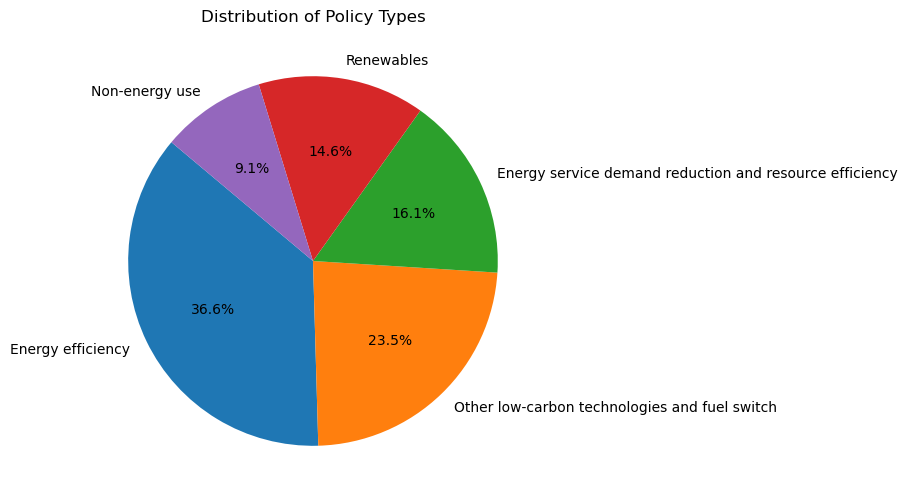

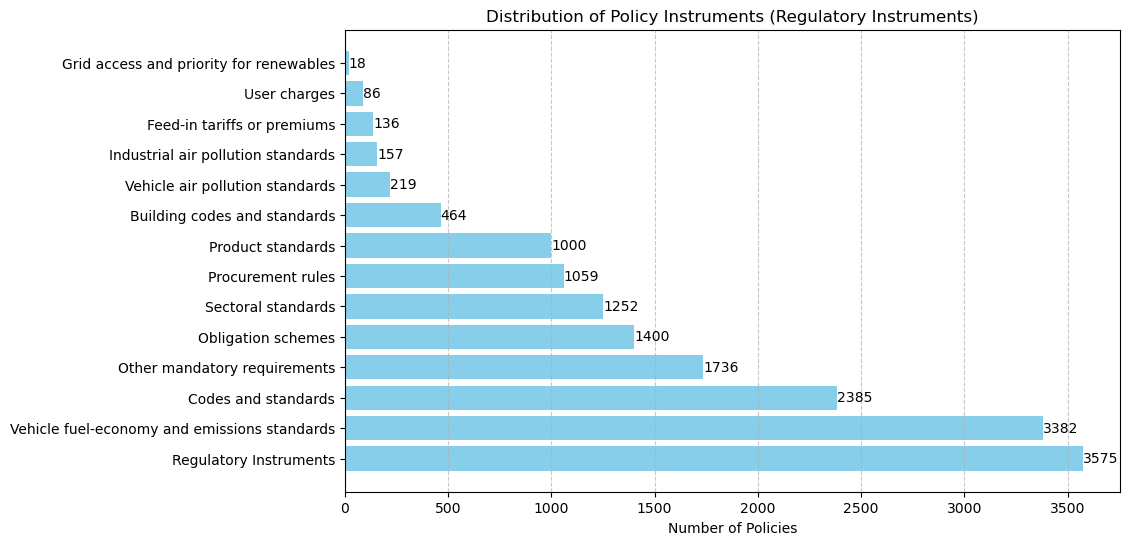

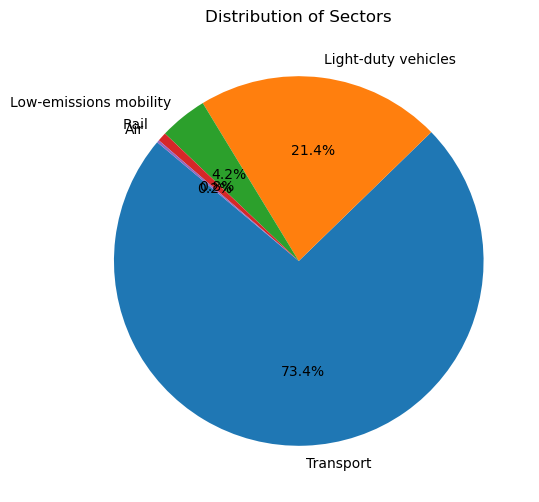

In [9]:
import matplotlib.pyplot as plt

# Value counts for policy_type and sector
policy_type_counts = df_sub["policy_type"].value_counts()
policy_instrument_counts = df_sub["policy_instrument"].value_counts()
policy_sector_counts = df_sub["sector"].value_counts()

# Create pie chart for policy_type in a separate figure
plt.figure(figsize=(8, 6))
plt.pie(policy_type_counts, labels=policy_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Policy Types')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(policy_instrument_counts.index, policy_instrument_counts.values, color='skyblue')
plt.xlabel('Number of Policies')
plt.title('Distribution of Policy Instruments (Regulatory Instruments)')

# Add value labels to the bars
for index, value in enumerate(policy_instrument_counts.values):
    plt.text(value, index, f'{value}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(policy_sector_counts, labels=policy_sector_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sectors')
plt.show()

#### Number of Transportation Policies (Excluding Air and Rail) vs. Non-Electric Car sales

In [10]:
df = df_sub[df_sub["sector"] != "Air"]
df = df[df["sector"] != "Rail"]
df.head()

country_iso country_update  \
12          ARE         Annual   
47          ARE         Annual   
157         FRA       Sporadic   
157         FRA       Sporadic   
211         FRA       Sporadic   

                                          policy_title        jurisdiction  \
12   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
47   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
157  Establishment of States Exemplary Role in Ener...             Country   
157  Establishment of States Exemplary Role in Ener...             Country   
211  Promotion of Electric and Natural-Gas Powered ...             Country   

                  country       policy_instrument     sector  \
12   United Arab Emirates  Regulatory Instruments  Transport   
47   United Arab Emirates  Regulatory Instruments  Transport   
157                France       Procurement rules  Transport   
157                France  Regulatory Instruments  Transport   
211                France       Procurement rules  Transport   

    policy_description        policy_type policy_status  ...  VarID  Variant  \
12                 NaN  Energy efficiency      In force  ...      2   Medium   
47                 NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
211                NaN         Renewables      In force  ...      2   Medium   

     Time MidPeriod    PopMale  PopFemale   PopTotal  PopDensity  \
12   2023    2023.5   6970.756   3194.394  10165.150     121.593   
47   2024    2024.5   7008.276   3236.726  10245.002     122.548   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
211  2005    2005.5  29590.144  31529.984  61120.128     111.623   

       sector_group policy_instrument_group  
12   Transportation  Regulatory Instruments  
47   Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
211  Transportation  Regulatory Instruments  

[5 rows x 38 columns]

In [11]:
df_car_sales = pd.read_csv("new_data/transportation/car-sales.csv")
df_car_sales = df_car_sales.dropna()
df_car_sales.head()

Entity Code  Year  Electric cars sold  Non-electric car sales
0  Australia  AUS  2012                 250                833083.4
1  Australia  AUS  2013                 290                852651.1
2  Australia  AUS  2014                1320                823680.0
3  Australia  AUS  2015                1760                878240.0
4  Australia  AUS  2016                1370                911963.3

In [12]:
df_non_elec_car = df_car_sales.drop(columns=['Electric cars sold'])
df_non_elec_car.head()

Entity Code  Year  Non-electric car sales
0  Australia  AUS  2012                833083.4
1  Australia  AUS  2013                852651.1
2  Australia  AUS  2014                823680.0
3  Australia  AUS  2015                878240.0
4  Australia  AUS  2016                911963.3

In [13]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df['policy_count'] = 1  # Add a column to count policies
policies_agg = df.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_non_elec_car,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] <= 2021]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Non-electric car sales',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Non-electric car sales',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Non-electric car sales'])
    plt.title(f'Correlation between Number of Policies and Number of non-electric car sales in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Non-electric car sales')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2010, description='Year:', max=2021, min=2010), Output()), _dom_classes=…

In [16]:
# Function to calculate and store data without plotting
def calculate_and_store_data(df, graph_name, col):
    for year in df['Year'].unique():
        # Filter the data for the selected year
        df_year = df[df['Year'] == year]
        
        if df_year.empty:
            continue

        # Calculate the correlation between policy count and renewable energy consumption
        correlation = df_year['policy_count'].corr(df_year[col])
        num_policies = df_year['policy_count'].sum()

        # Store the data in the dictionary
        data['graph_name'].append(graph_name)
        data['year'].append(year)
        data['correlation_value'].append(correlation)
        data['num_policies'].append(num_policies)

# Run the function to calculate and store the data
calculate_and_store_data(df_combined, 'non_electric_car_sales', 'Non-electric car sales')

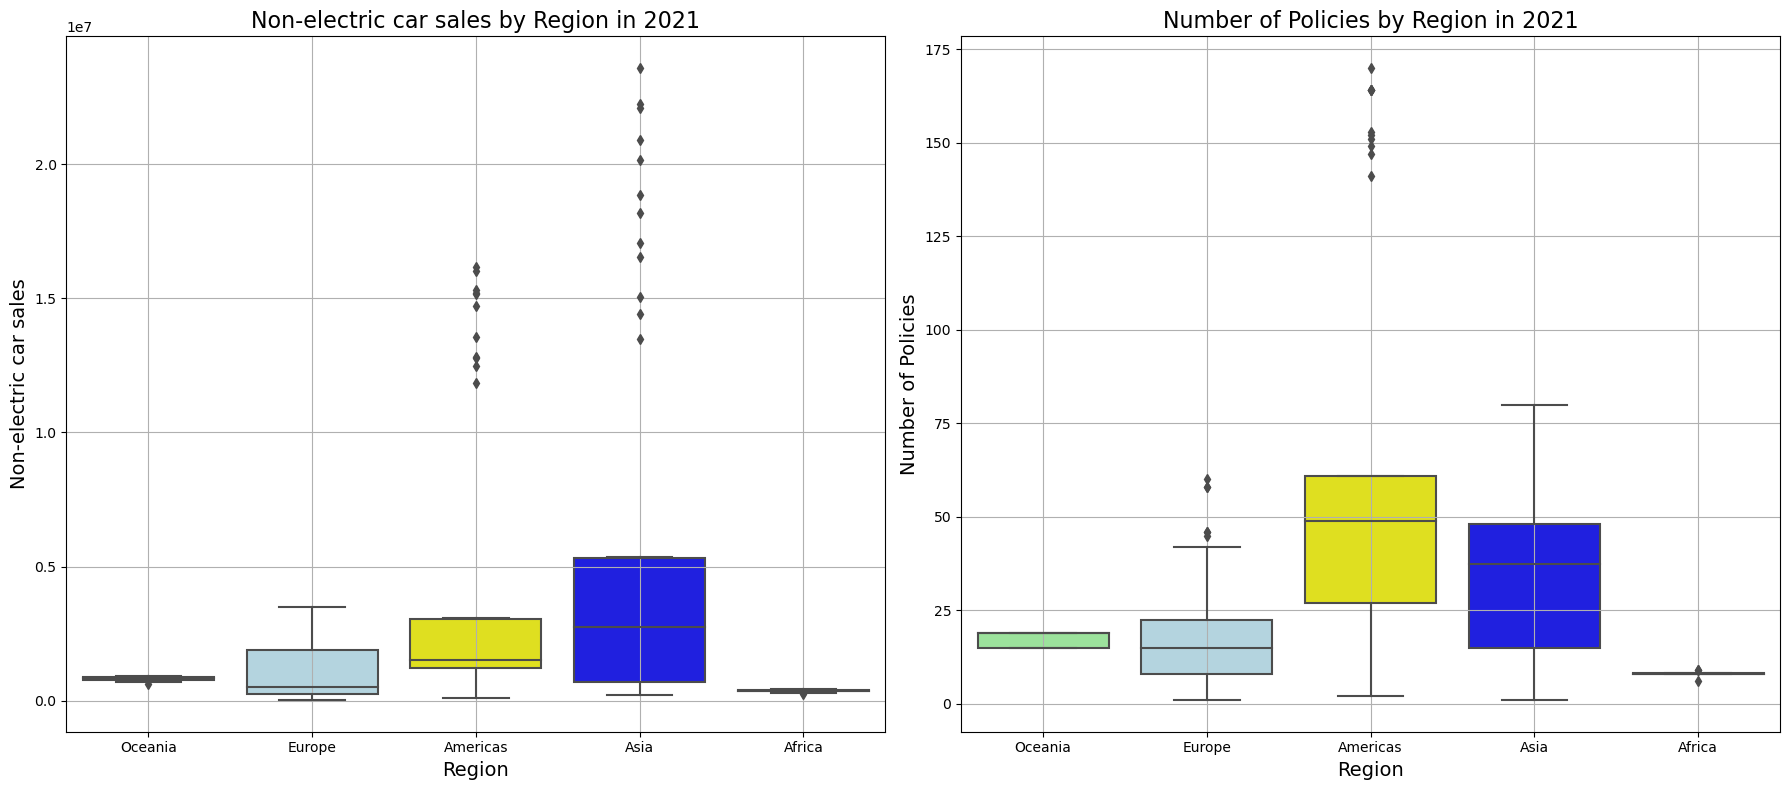

In [17]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Non-electric car sales',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Non-electric car sales by Region in 2021', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Non-electric car sales', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Policies by Region in 2021', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

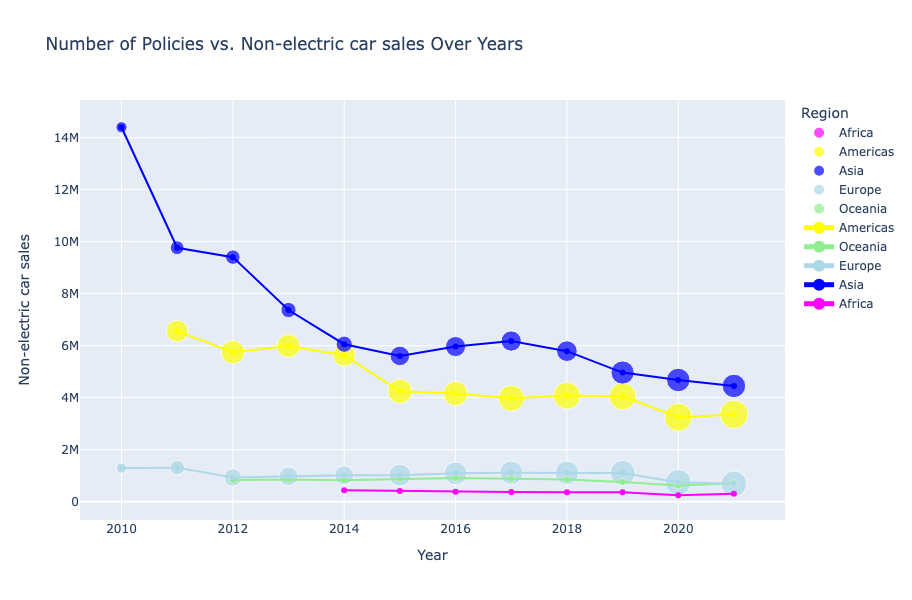

In [18]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Non-electric car sales': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Renewables (% equivalent primary energy)': 'Avg Share of Renewables'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_renewables_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Non-electric car sales',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Non-electric car sales Over Years',
        labels={'policy_count': 'Number of Policies', 'Non-electric car sales': 'Non-electric car sales'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Non-electric car sales'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Non-electric car sales: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Non-electric car sales',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_renewables_interactive(region_agg)

#### Number of Transportation Policies (Excluding Air and Rail) vs. Electric Car sales

In [19]:
df_elec_car = df_car_sales.drop(columns=['Non-electric car sales'])
df_elec_car.head()

Entity Code  Year  Electric cars sold
0  Australia  AUS  2012                 250
1  Australia  AUS  2013                 290
2  Australia  AUS  2014                1320
3  Australia  AUS  2015                1760
4  Australia  AUS  2016                1370

In [20]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df['policy_count'] = 1  # Add a column to count policies
policies_agg = df.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_elec_car,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] <= 2021]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Electric cars sold',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Electric cars sold',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Electric cars sold'])
    plt.title(f'Correlation between Number of Policies and Number of electric car sales in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Electric cars sold')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2010, description='Year:', max=2021, min=2010), Output()), _dom_classes=…

In [21]:
# Run the function to calculate and store the data
calculate_and_store_data(df_combined, 'electric_car_sales', 'Electric cars sold')

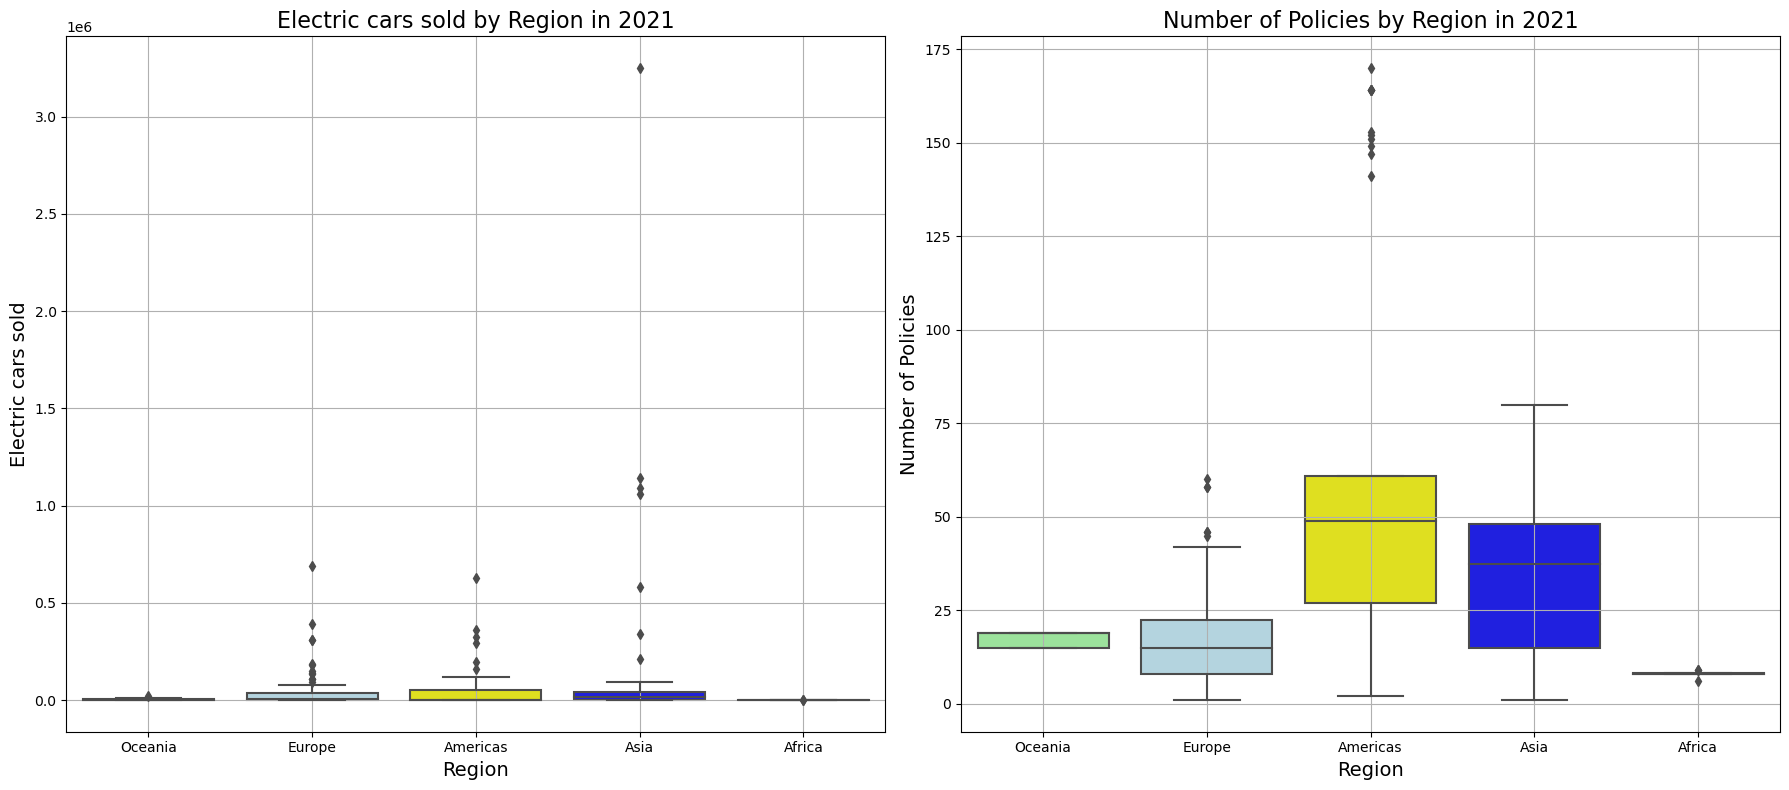

In [22]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Electric cars sold',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Electric cars sold by Region in 2021', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Electric cars sold', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Policies by Region in 2021', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

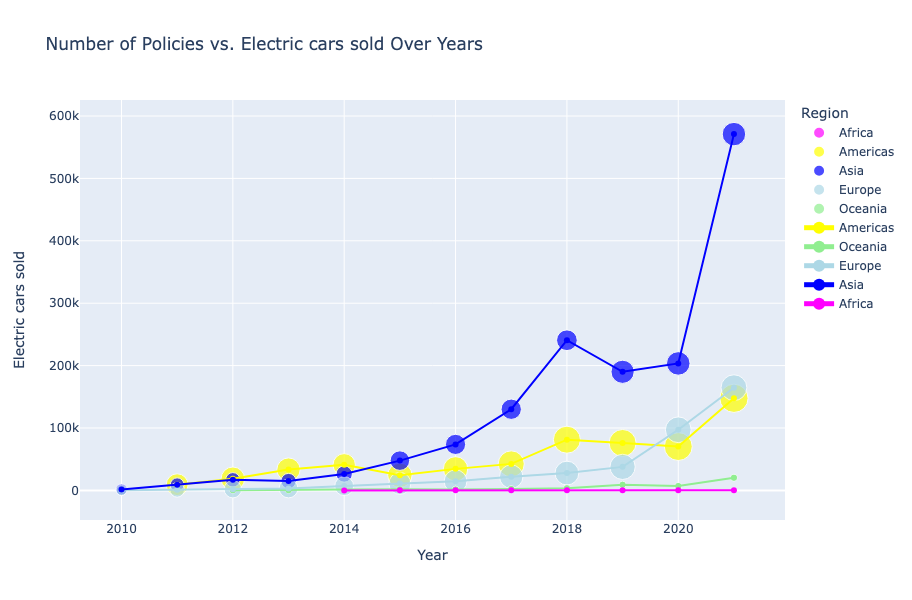

In [23]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Electric cars sold': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Renewables (% equivalent primary energy)': 'Avg Share of Renewables'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_renewables_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Electric cars sold',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Electric cars sold Over Years',
        labels={'policy_count': 'Number of Policies', 'Non-electric car sales': 'Non-electric car sales'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Electric cars sold'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Electric cars sold: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Electric cars sold',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_renewables_interactive(region_agg)

#### Number of Rail Transportation Policies vs. Number of Air Passengers

In [24]:
df = df_sub[df_sub["sector"].isin(["Rail", "Transport"])]
df.head()

country_iso country_update  \
12          ARE         Annual   
47          ARE         Annual   
157         FRA       Sporadic   
157         FRA       Sporadic   
211         FRA       Sporadic   

                                          policy_title        jurisdiction  \
12   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
47   Dubai Energy Efficiency Target United Arab Emi...  Subnational region   
157  Establishment of States Exemplary Role in Ener...             Country   
157  Establishment of States Exemplary Role in Ener...             Country   
211  Promotion of Electric and Natural-Gas Powered ...             Country   

                  country       policy_instrument     sector  \
12   United Arab Emirates  Regulatory Instruments  Transport   
47   United Arab Emirates  Regulatory Instruments  Transport   
157                France       Procurement rules  Transport   
157                France  Regulatory Instruments  Transport   
211                France       Procurement rules  Transport   

    policy_description        policy_type policy_status  ...  VarID  Variant  \
12                 NaN  Energy efficiency      In force  ...      2   Medium   
47                 NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
157                NaN  Energy efficiency      In force  ...      2   Medium   
211                NaN         Renewables      In force  ...      2   Medium   

     Time MidPeriod    PopMale  PopFemale   PopTotal  PopDensity  \
12   2023    2023.5   6970.756   3194.394  10165.150     121.593   
47   2024    2024.5   7008.276   3236.726  10245.002     122.548   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
157  2005    2005.5  29590.144  31529.984  61120.128     111.623   
211  2005    2005.5  29590.144  31529.984  61120.128     111.623   

       sector_group policy_instrument_group  
12   Transportation  Regulatory Instruments  
47   Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
157  Transportation  Regulatory Instruments  
211  Transportation  Regulatory Instruments  

[5 rows x 38 columns]

In [25]:
df_rail_passengers = pd.read_csv('new_data/transportation/railways-passengers-carried-passenger-km.csv')
df_rail_passengers.head()

Entity Code  Year  Railways, passengers carried (million passenger-km)
0  Albania  ALB  1995                                        197000000.0  
1  Albania  ALB  1996                                        168000000.0  
2  Albania  ALB  1997                                         95000000.0  
3  Albania  ALB  1998                                        116000000.0  
4  Albania  ALB  1999                                        121000000.0

In [26]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df['policy_count'] = 1  # Add a column to count policies
policies_agg = df.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_rail_passengers,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] <= 2021]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Railways, passengers carried (million passenger-km)',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Railways, passengers carried (million passenger-km)',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Railways, passengers carried (million passenger-km)'])
    plt.title(f'Correlation between Number of Policies and Number of Policies vs Railways, passengers carried (million passenger-km) in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Railways, passengers carried (million passenger-km)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=1995, description='Year:', max=2021, min=1995), Output()), _dom_classes=…

In [27]:
calculate_and_store_data(df_combined, f'rail_passengers', 'Railways, passengers carried (million passenger-km)')

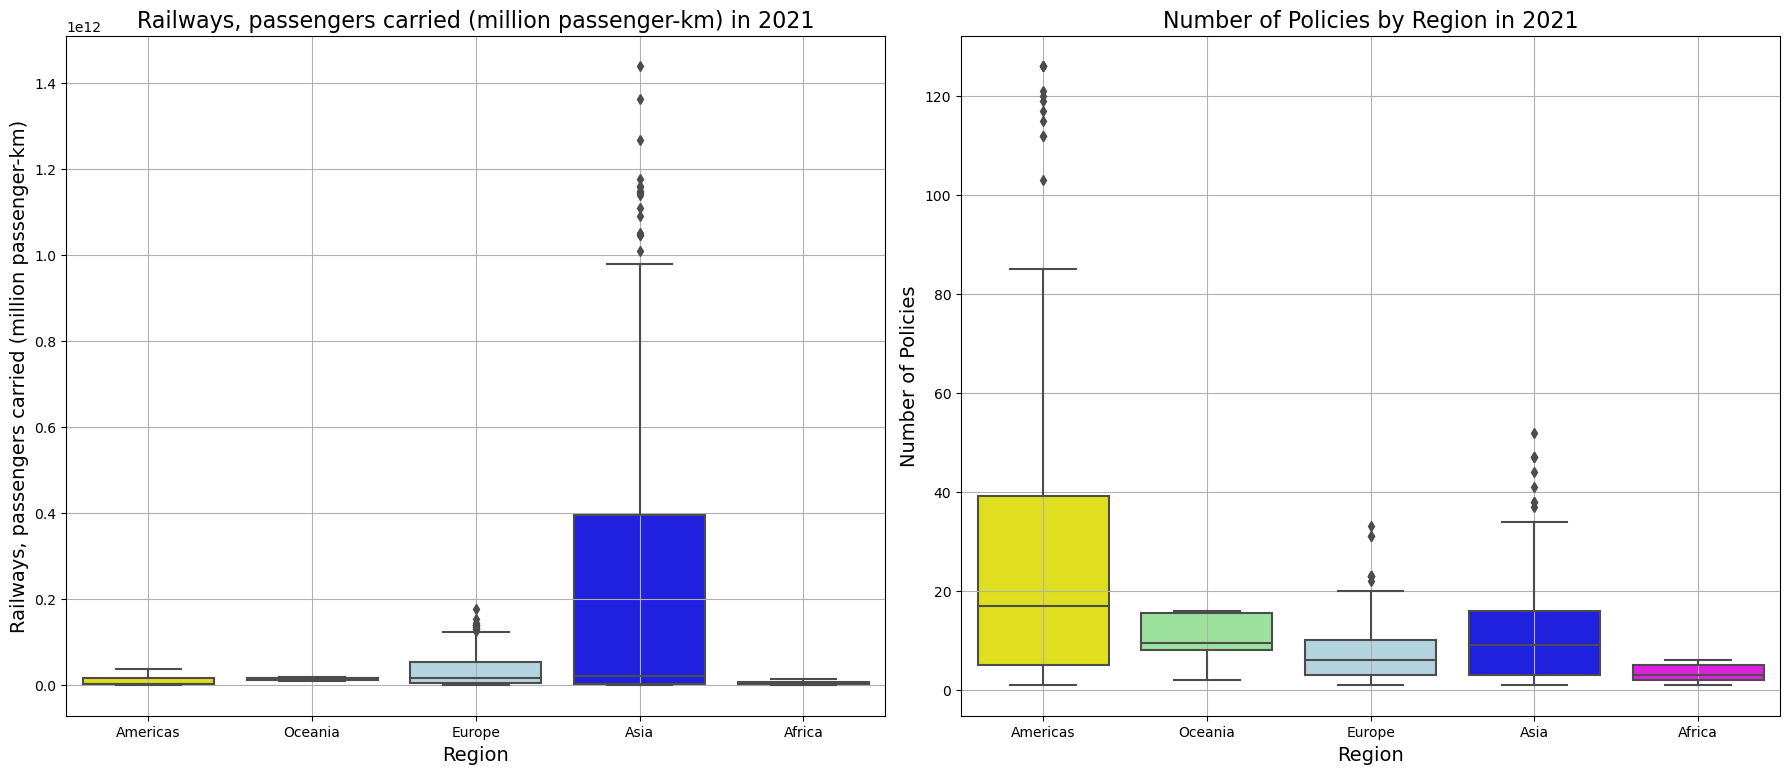

In [28]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Railways, passengers carried (million passenger-km)',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Railways, passengers carried (million passenger-km) in 2021', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Railways, passengers carried (million passenger-km)', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Policies by Region in 2021', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

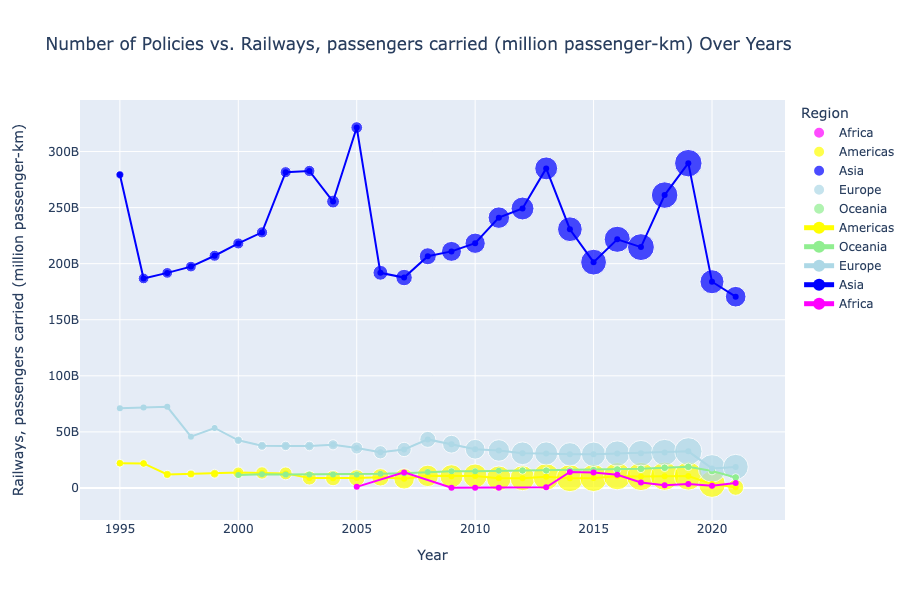

In [29]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Railways, passengers carried (million passenger-km)': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Railways, passengers carried (million passenger-km)': 'Avg Share of Fossil Fuels'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Railways, passengers carried (million passenger-km)',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Railways, passengers carried (million passenger-km) Over Years',
        labels={'policy_count': 'Number of Policies', 'Railways, passengers carried (million passenger-km)': 'Railways, passengers carried (million passenger-km)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Railways, passengers carried (million passenger-km)'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Railways, passengers carried (million passenger-km): %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Railways, passengers carried (million passenger-km)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_interactive(region_agg)

#### Number of Energy Policies vs CO₂ and Greenhouse Gas Emissions

In [30]:
df_ghg_emission = pd.read_csv('new_data/energy/per-capita-ghg-emissions.csv')
df_ghg_emission = df_ghg_emission.dropna()
df_ghg_emission.head()

Entity Code  Year  \
0  Afghanistan  AFG  1850   
1  Afghanistan  AFG  1851   
2  Afghanistan  AFG  1852   
3  Afghanistan  AFG  1853   
4  Afghanistan  AFG  1854   

   Per-capita greenhouse gas emissions in CO₂ equivalents  
0                                           1.955458       
1                                           1.964986       
2                                           1.972589       
3                                           1.979090       
4                                           1.985106

In [31]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_sub['policy_count'] = 1  # Add a column to count policies
policies_agg = df_sub.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_ghg_emission,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Per-capita greenhouse gas emissions in CO₂ equivalents'])
    plt.title(f'Correlation between Number of Policies and Number of Transportation Policies vs Per-capita greenhouse gas emissions in CO₂ equivalents in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Per-capita greenhouse gas emissions in CO₂ equivalents')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2022, min=2000), Output()), _dom_classes=…

In [32]:
calculate_and_store_data(df_combined, f'ghg_emissions', 'Per-capita greenhouse gas emissions in CO₂ equivalents')

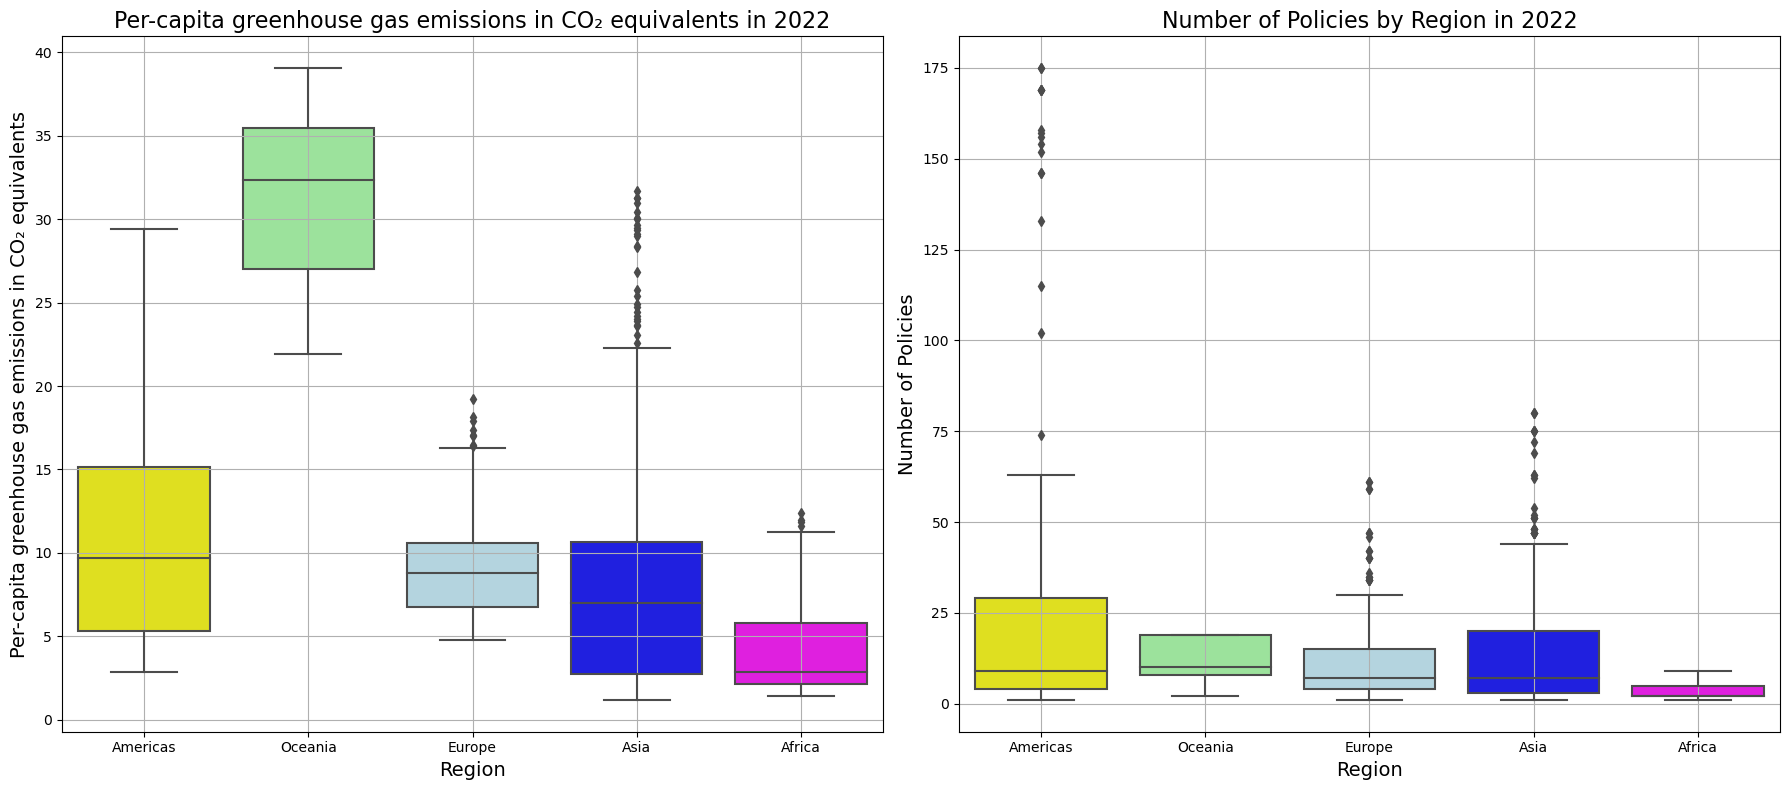

In [31]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Per-capita greenhouse gas emissions in CO₂ equivalents in 2022', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Per-capita greenhouse gas emissions in CO₂ equivalents', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Policies by Region in 2022', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

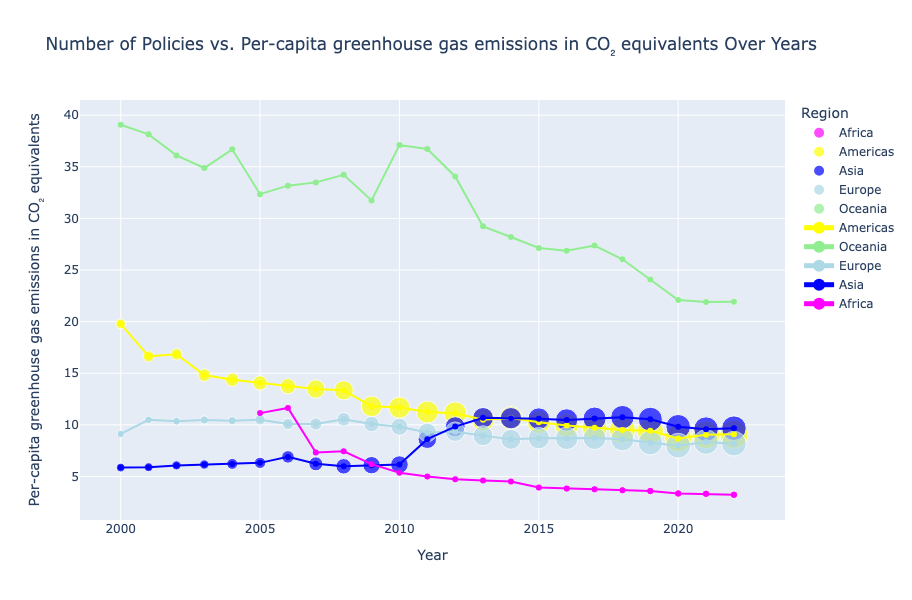

In [32]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Per-capita greenhouse gas emissions in CO₂ equivalents': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Per-capita greenhouse gas emissions in CO₂ equivalents': 'Per-capita greenhouse gas emissions in CO₂ equivalents'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_ghg_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Per-capita greenhouse gas emissions in CO₂ equivalents Over Years',
        labels={'policy_count': 'Number of Policies', 'Per-capita greenhouse gas emissions in CO₂ equivalents': 'Per-capita greenhouse gas emissions in CO₂ equivalents'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Per-capita greenhouse gas emissions in CO₂ equivalents'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Fossil Fuels: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Per-capita greenhouse gas emissions in CO₂ equivalents',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_ghg_interactive(region_agg)

#### Number of Energy Policies vs Outdoor Air Pollution

In [33]:
df_air_pollution = pd.read_csv('new_data/pollution/pm25-air-pollution.csv')
df_air_pollution = df_air_pollution.dropna()
df_air_pollution.head()

Entity Code  Year  \
0  Afghanistan  AFG  2010   
1  Afghanistan  AFG  2011   
2  Afghanistan  AFG  2012   
3  Afghanistan  AFG  2013   
4  Afghanistan  AFG  2014   

   Concentrations of fine particulate matter (PM2.5) - Residence area type: Total  
0                                           68.96605                               
1                                           66.94454                               
2                                           68.25744                               
3                                           72.18289                               
4                                           68.05715

In [34]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_sub['policy_count'] = 1  # Add a column to count policies
policies_agg = df_sub.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_air_pollution,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Concentrations of fine particulate matter (PM2.5) - Residence area type: Total',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Concentrations of fine particulate matter (PM2.5) - Residence area type: Total',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Concentrations of fine particulate matter (PM2.5) - Residence area type: Total'])
    plt.title(f'Correlation between Number of Policies and Number of Transportation Policies vs Concentrations of fine particulate matter (PM2.5) in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Concentrations of fine particulate matter (PM2.5)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2010, description='Year:', max=2019, min=2010), Output()), _dom_classes=…

In [35]:
calculate_and_store_data(df_combined, f'air_pollution', 'Concentrations of fine particulate matter (PM2.5) - Residence area type: Total')

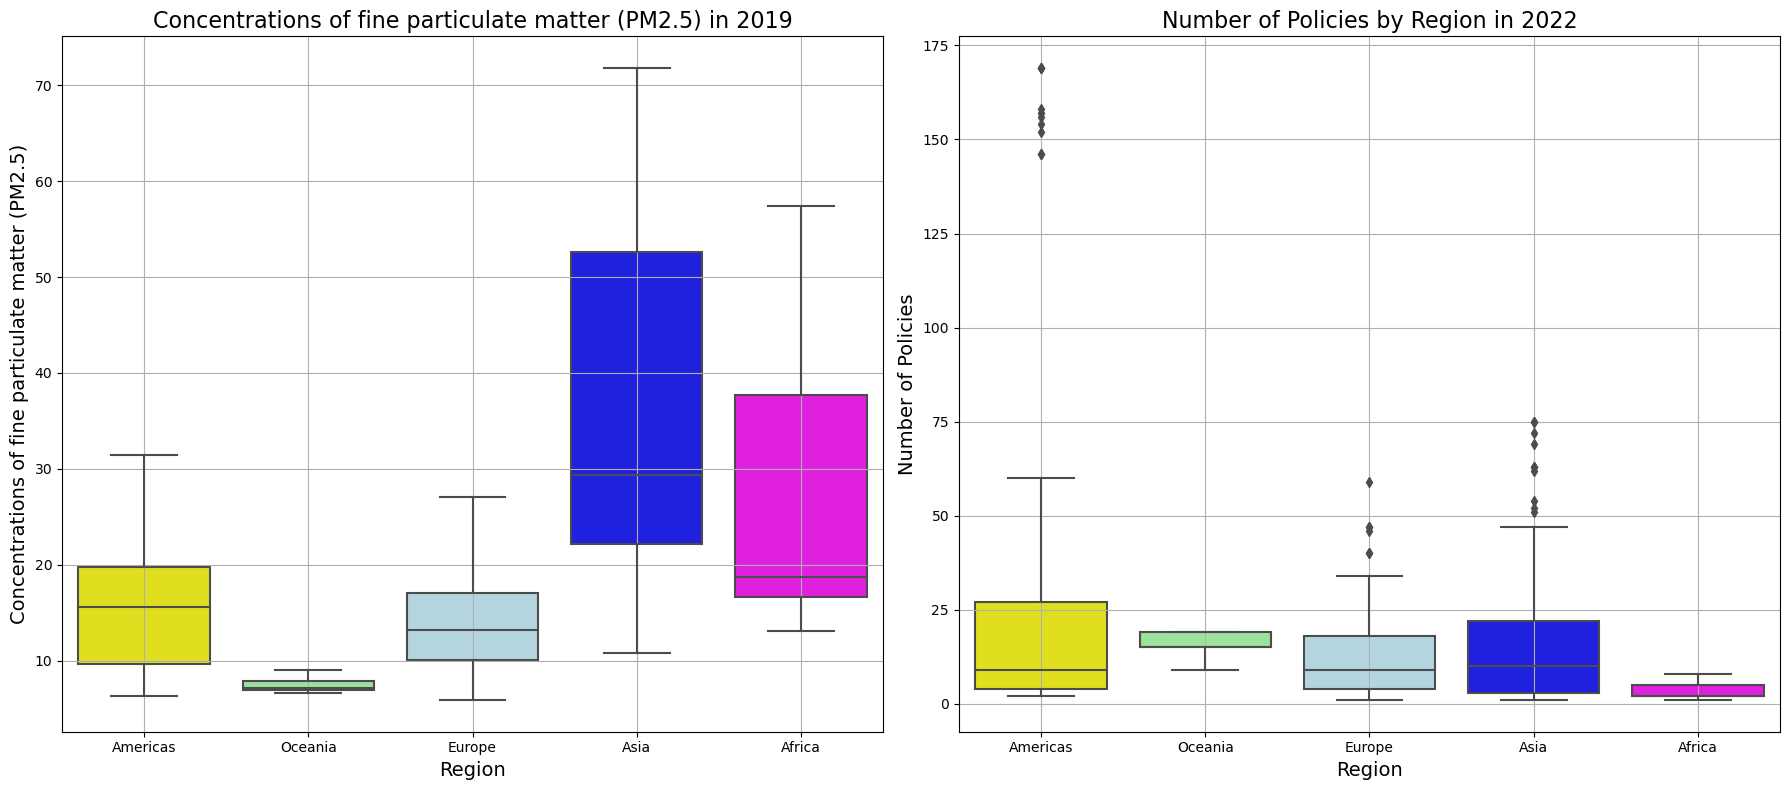

In [36]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Concentrations of fine particulate matter (PM2.5) - Residence area type: Total',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Concentrations of fine particulate matter (PM2.5) in 2019', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Concentrations of fine particulate matter (PM2.5)', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Policies by Region in 2022', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

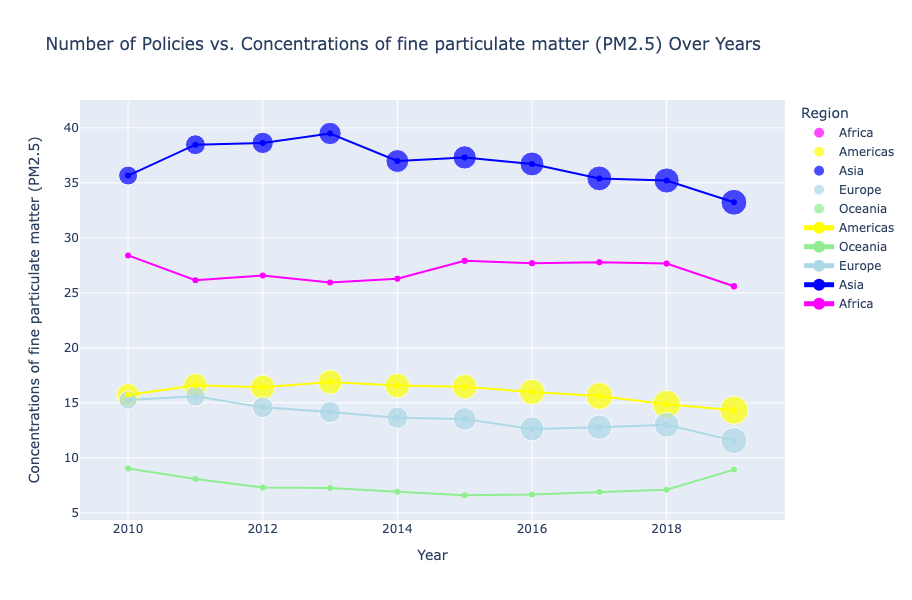

In [37]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Concentrations of fine particulate matter (PM2.5) - Residence area type: Total': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
region_agg.rename(columns={'Concentrations of fine particulate matter (PM2.5) - Residence area type: Total': 'Concentrations of fine particulate matter (PM2.5)'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_ghg_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Concentrations of fine particulate matter (PM2.5)',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Concentrations of fine particulate matter (PM2.5) Over Years',
        labels={'policy_count': 'Number of Policies', 'Concentrations of fine particulate matter (PM2.5)': 'Concentrations of fine particulate matter (PM2.5)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Concentrations of fine particulate matter (PM2.5)'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Concentrations of fine particulate matter (PM2.5): %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Concentrations of fine particulate matter (PM2.5)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_ghg_interactive(region_agg)

### Save data

In [38]:
df = pd.DataFrame(data)
df.to_csv('out/2.2_policy_instrument.csv', index=False)